In [61]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm

from fredapi import Fred
import tqdm as tqdm
from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from joblib import Parallel, delayed

from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

# Params

In [62]:
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 126
current_date = (date.today()).strftime('%Y-%m-%d')

# Create Log Price

In [63]:
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')

In [64]:
# Compute log price
price['log_price'] = price.groupby('permno')['Close'].transform(np.log)

# Execute PCA

In [65]:
# Get PCA General Componenets
pca_df = price['log_price'].unstack(price.index.names[0])
num_components = 5
pca_data = rolling_pca(data=pca_df, window_size=window, num_components=num_components, name='log')

In [66]:
pca_data = pca_data.replace([np.inf, -np.inf], np.nan)

In [67]:
pca_data = pca_data.fillna(0)

# Execute AR Predictions for PCA Components

In [68]:
start_time = time.time()
def process_column(column):
    print(f"Processing {column}")
    column_predictions = []
    dates = []
    series = pca_data[column]
    for t in range(4, len(series) + 1):
        train_series = series.iloc[:t]
        if len(train_series) < 3:
            continue

        # Estimating AR(1) using AutoReg
        model = AutoReg(train_series, lags=1, old_names=False)
        result = model.fit()

        # Predicting for the next time step
        prediction = result.predict(start=len(train_series), end=len(train_series)).iloc[0]

        # Appending the prediction
        column_predictions.append(prediction)
        dates.append(series.index[t-1])

    temp_df = pd.DataFrame({
        'date': dates,
        column: column_predictions
    })

    return temp_df

# Parallelization
result_list = Parallel(n_jobs=-1, verbose=5)(delayed(process_column)(column) for column in pca_data.columns)

# Merging results
predictions = pd.concat(result_list, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.9s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished


In [69]:
# Start with an empty DataFrame with just the 'date' column from the first result
merged_predictions = result_list[0][['date']].copy()

# Merge each DataFrame in result_list with merged_predictions based on 'date'
for df in result_list:
    merged_predictions = pd.merge(merged_predictions, df, on='date', how='outer')

# Now, set 'date' as the index
merged_predictions = merged_predictions.set_index('date')
merged_predictions = merged_predictions.sort_index()

# Predict Log Prices using LR

In [70]:
data = price[['log_price']]
factor_data = merged_predictions.copy(deep=True)
factor_col = factor_data.columns
ret = 'log_price'

In [71]:
betas = rolling_ols_parallel(data=data, ret=ret, factor_data=factor_data, factor_cols=factor_col.tolist(), window=window, name=f'log_pca')

In [72]:
pred_columns = betas.columns[betas.columns.str.contains('pred')].tolist()
pred_log_price = betas[pred_columns]
pred_log_price.columns = ['pred_log_pca']

# Backtest

In [73]:
price = create_return(price, [1])

In [74]:
backtest = pd.merge(price[['RET_01', 'Close']], pred_log_price, left_index=True, right_index=True, how='right')

In [75]:
# shift Close one day forward
backtest['RET_01'] = backtest.groupby('permno')['RET_01'].shift(-1)

In [76]:
backtest['pred_ret'] = (np.exp(backtest['pred_log_pca']) - backtest['Close']) / backtest['Close']

In [77]:
def assign_long_short_top_bottom_n(df, num_stock):
    # Create an empty column
    df['long'] = False
    df['short'] = False
    
    # Get indices for top and bottom stocks
    long_indices = df.groupby('date').head(num_stock).index
    short_indices = df.groupby('date').tail(num_stock).index
    
    # Assign True values for selected stocks
    df.loc[long_indices, 'long'] = True
    df.loc[short_indices, 'short'] = True
    
    # Return modified dataframe
    return df

In [78]:
num_stock = 100

# Sort by date and pred_ret
sorted_backtest = backtest.sort_values(by=['date', 'pred_ret'], ascending=[True, False])

# Assign long and short columns
sorted_backtest = assign_long_short_top_bottom_n(sorted_backtest, num_stock=num_stock)

# Assign weights
weight = 1/num_stock
sorted_backtest['weight'] = np.where(sorted_backtest['long'], weight, 
                                     np.where(sorted_backtest['short'], -weight, 0))

# Calculate portfolio returns
sorted_backtest['portfolio_ret'] = sorted_backtest['weight'] * sorted_backtest['RET_01']
portfolio_returns = sorted_backtest.groupby('date')['portfolio_ret'].sum()

# If you need the original order back
backtest = sorted_backtest.sort_index()

# Hedge Portfolio

In [79]:
# Get return data
def get_ret(ticker_list):
    data = get_data_fmp(ticker_list=ticker_list, start=start, current_date=current_date)
    data = data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
    data = data.rename(columns={'Adj Close': 'Close'})
    data = create_return(data, [1])
    data = data.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
    data = data.loc[~data.index.duplicated(keep='first')]
    data = data.fillna(0)
    return data

In [80]:
# Get commodity, real estate, bonds, and metal data
com_ticker = ['NEM', 'GOLD', 'FNV', 'WPM', 'AEM', 'XOM', 'CVX', 'SLB', 'COP', 'STLD', 'AMT', 'CCI', 'PLD', 
              'CTVA', 'SPG', 'EQIX', 'BND', 'AGG', 'BNDX', 'VCIT', 'MUB', 'VCSH', 'BSV', 'VTEB', 'IEF', 'MBB', 
              'GOVT', 'VGSH', 'TIP']
com_port = get_ret(com_ticker)

Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:39<00:00,  1.36s/ticker]


In [81]:
com_port['vol'] = com_port.groupby('ticker')['RET_01'].rolling(60).std().reset_index(level=0, drop=True)
com_port['inv_vol'] = 1 / com_port['vol']
com_port['norm_inv_vol'] = com_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
com_port['weighted_ret'] = com_port['RET_01'] * com_port['norm_inv_vol']
com_port = com_port.groupby('date')['weighted_ret'].sum()
com_port = com_port.to_frame()
com_port.columns = ['comm_ret']

### Macro

In [82]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
interest = fred.get_series("REAINTRATREARAT1YE").to_frame()
interest.columns = ['RIR']
interest = interest.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
interest = interest.reset_index()
interest = pd.merge_asof(date, interest, left_on='date', right_on='index', direction='backward')
interest = interest.set_index('date').drop('index', axis=1)
interest = interest.ffill()

In [83]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
cpi = fred.get_series("CORESTICKM159SFRBATL").to_frame()
cpi.columns = ['CPI']
cpi = cpi.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
cpi = cpi.reset_index()
cpi = pd.merge_asof(date, cpi, left_on='date', right_on='index', direction='backward')
cpi = cpi.set_index('date').drop('index', axis=1)
cpi = cpi.ffill()

In [84]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
yield_curve = fred.get_series("T10Y2Y").to_frame()
yield_curve.columns = ['YIELD']
yield_curve = yield_curve.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
yield_curve = yield_curve.reset_index()
yield_curve = pd.merge_asof(date, yield_curve, left_on='date', right_on='index', direction='backward')
yield_curve = yield_curve.set_index('date').drop('index', axis=1)
yield_curve = yield_curve.ffill()

In [85]:
macro = pd.concat([interest, cpi, yield_curve], axis=1)

In [86]:
macro['RIR_z'] = (macro['RIR'] - macro['RIR'].mean()) / macro['RIR'].std()
macro['CPI_z'] = (macro['CPI'] - macro['CPI'].mean()) / macro['CPI'].std()
macro['YIELD_z'] = (macro['YIELD'] - macro['YIELD'].mean()) / macro['YIELD'].std()
macro['mt'] = macro[['RIR_z', 'CPI_z', 'YIELD_z']].mean(axis=1)

In [87]:
T = [21, 60]
for t in T:
    macro[f'mt_{t}'] = macro['mt'].rolling(t).mean()

In [88]:
# Macro
macro_buy = (macro['mt_21'] > macro['mt_60'])
macro_buy_df = macro_buy.to_frame('macro_buy')

In [89]:
def calc_macro_port(row, col1, col2):
    if row['macro_buy']:
        return 0.50 * row[col1] + 0.50 * row[col2]
    else:
        return 0.25 * row[col1] + 0.75 * row[col2]

## Plot

In [90]:
comb_inv_ret = pd.merge(portfolio_returns.to_frame('port_ret'), com_port, left_index=True, right_index=True, how='left')
comb_inv_ret = comb_inv_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = comb_inv_ret.columns[0], comb_inv_ret.columns[1]
comb_inv_ret['total_ret'] = comb_inv_ret.apply(calc_macro_port, args=(col1, col2), axis=1)
comb_inv_total = comb_inv_ret['total_ret']

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ------------
Start Period               2005-07-08   2005-07-08
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          267.33%      14,557.15%
CAGR﹪                     5.02%        20.64%

Sharpe                     0.46         1.7
Prob. Sharpe Ratio         97.54%       100.0%
Smart Sharpe               0.42         1.53
Sortino                    0.64         2.78
Smart Sortino              0.58         2.51
Sortino/√2                 0.46         1.97
Smart Sortino/√2           0.41         1.78
Omega                      1.37         1.37

Max Drawdown               -56.47%      -57.89%
Longest DD Days            1982         885
Volatility (ann.)          19.59%       16.88%
R^2                        0.0          0.0
Information Ratio          0.05         0.05
Calmar         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-06-09,2023-11-09,2023-11-10,885,-57.886386,-55.060520
2,2020-01-06,2020-03-17,2020-04-21,107,-18.206212,-14.755360
3,2020-08-10,2020-09-01,2020-11-16,99,-16.550936,-16.027240
4,2019-09-16,2019-11-25,2019-12-26,102,-14.501295,-14.351564
5,2021-03-15,2021-04-19,2021-05-27,74,-13.438614,-12.136080


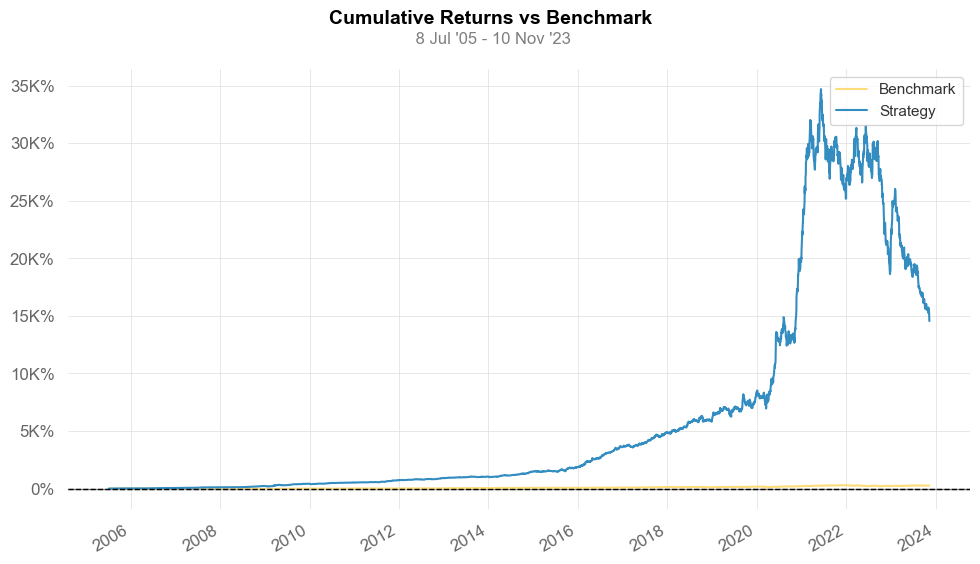

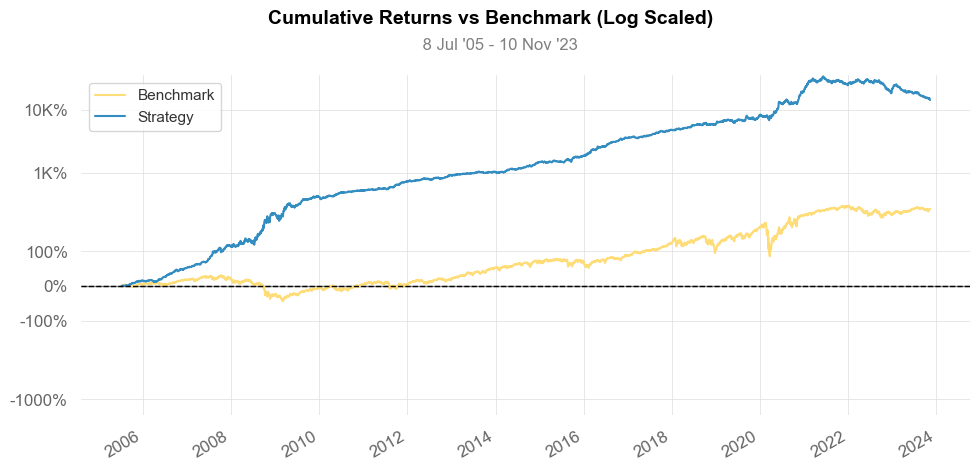

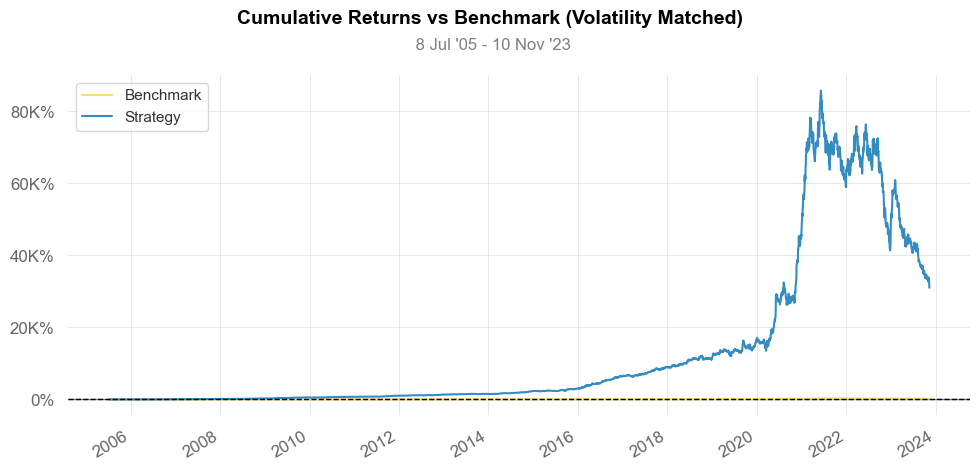

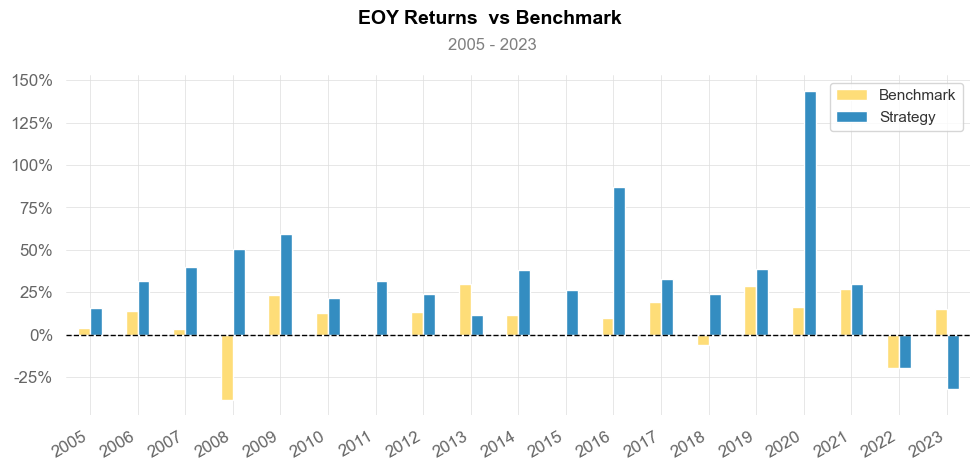

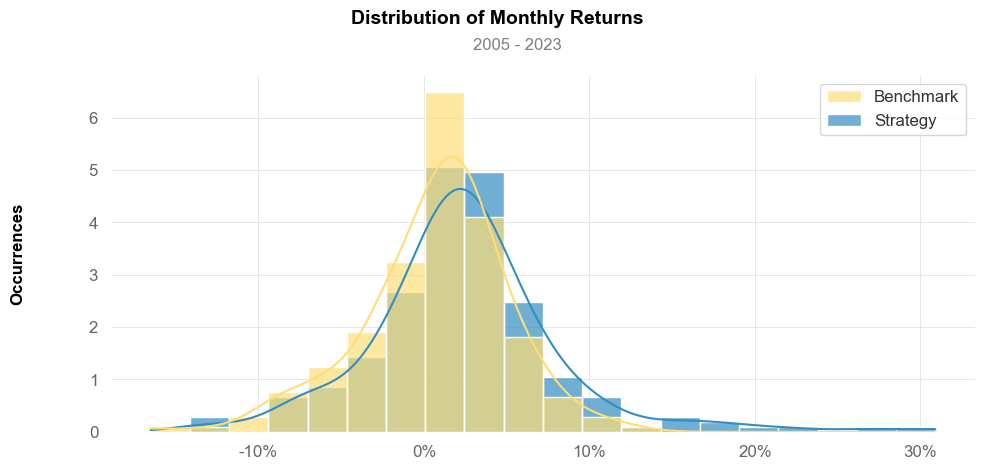

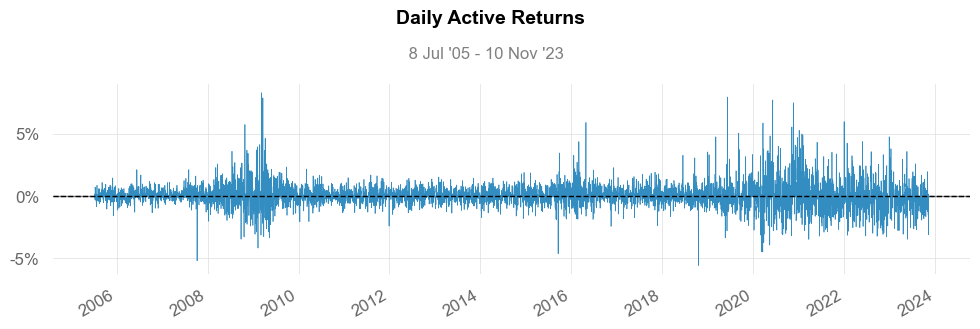

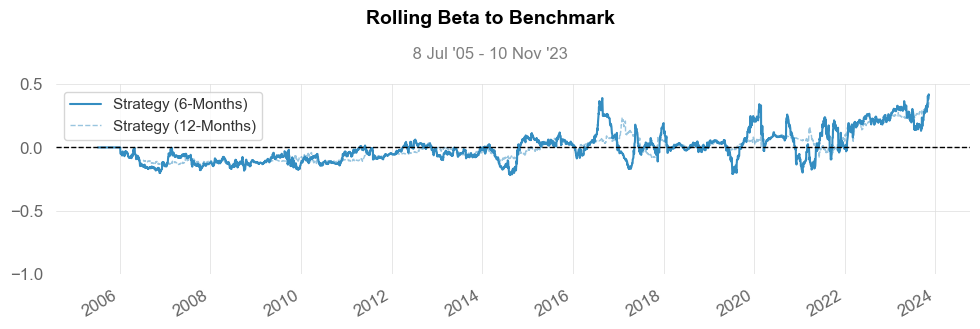

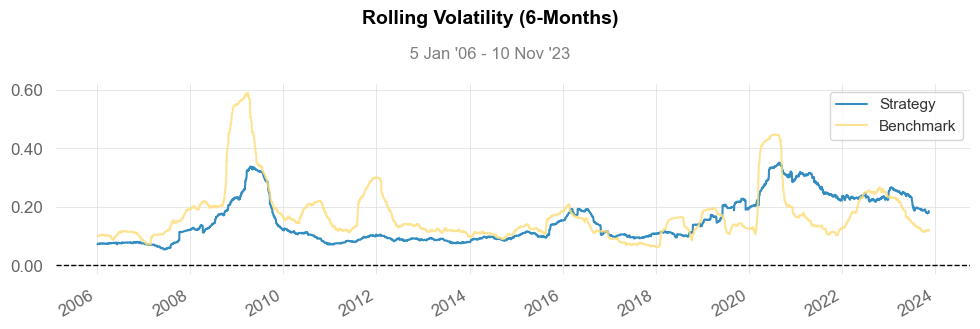

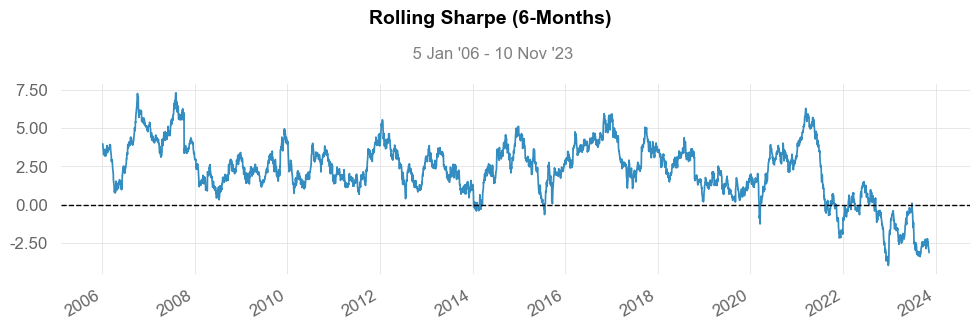

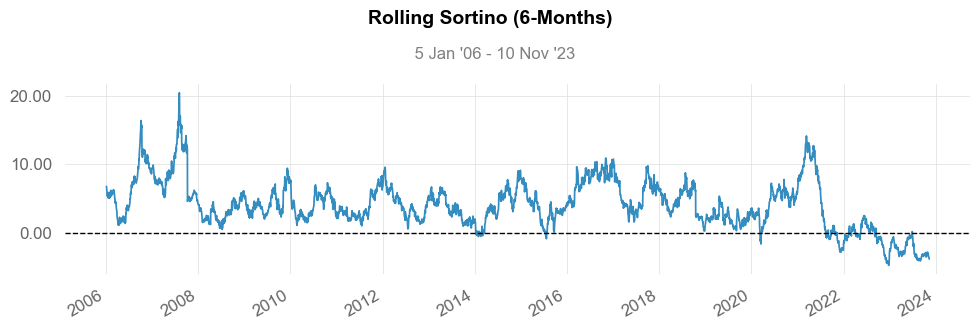

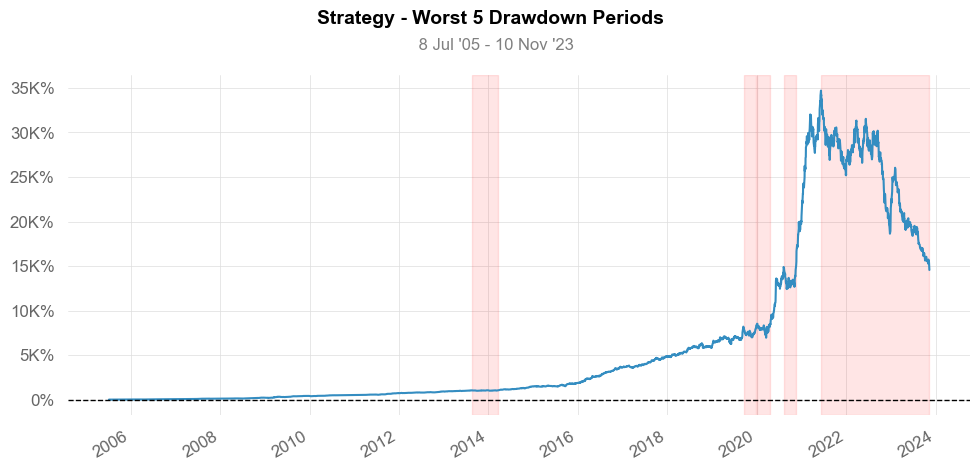

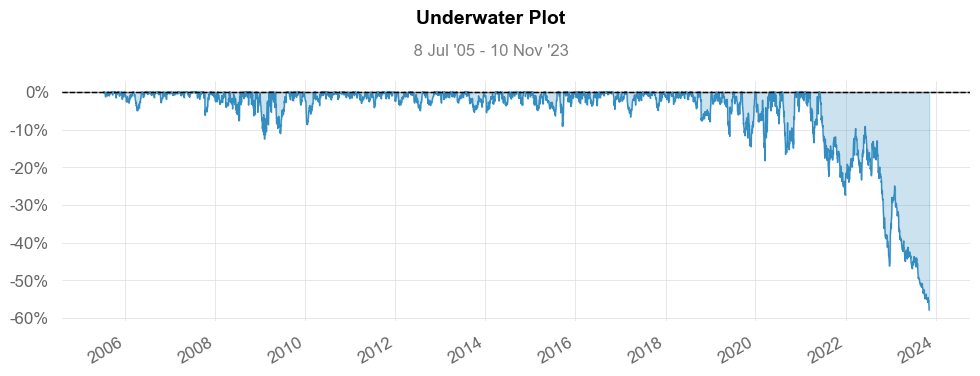

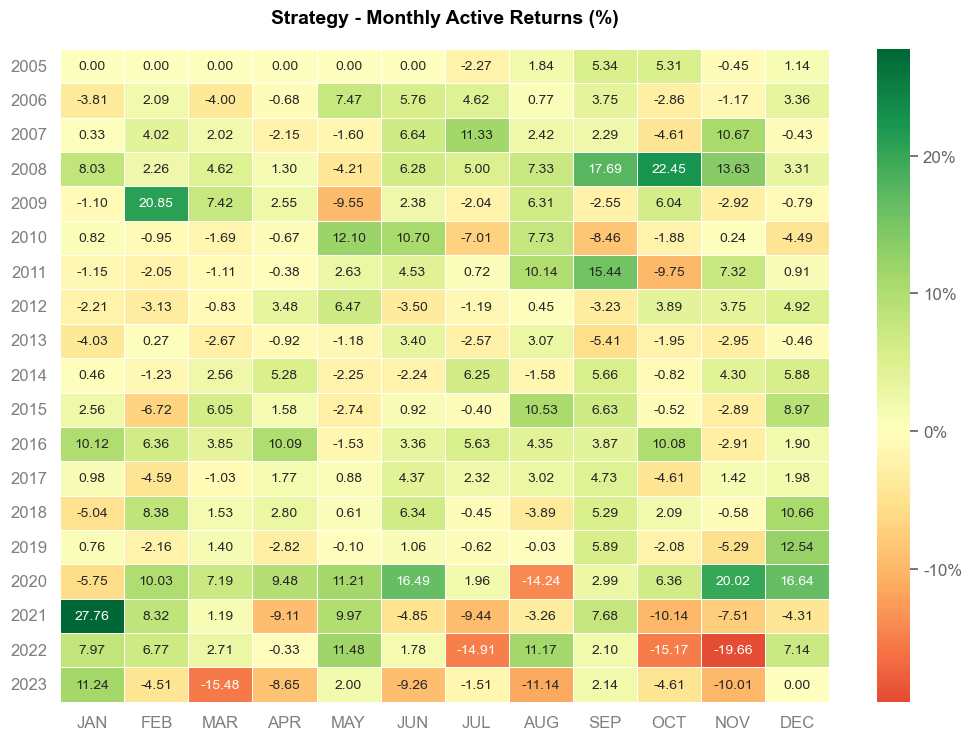

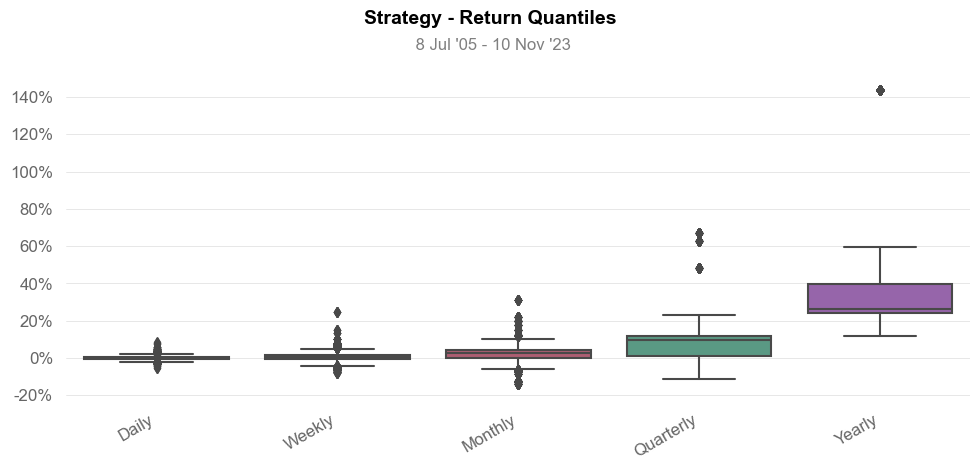

In [92]:
qs.reports.full(portfolio_returns, "SPY", figsize=(10, 5))